<Figure size 1000x600 with 0 Axes>

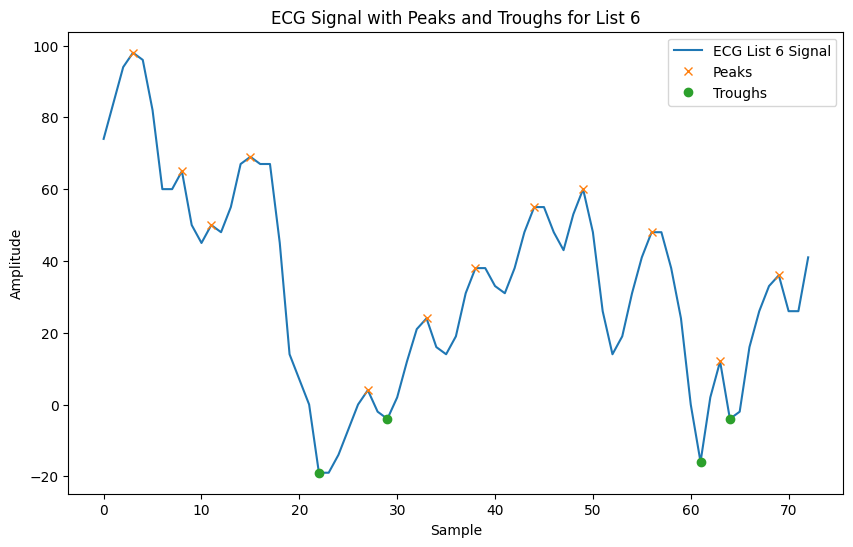

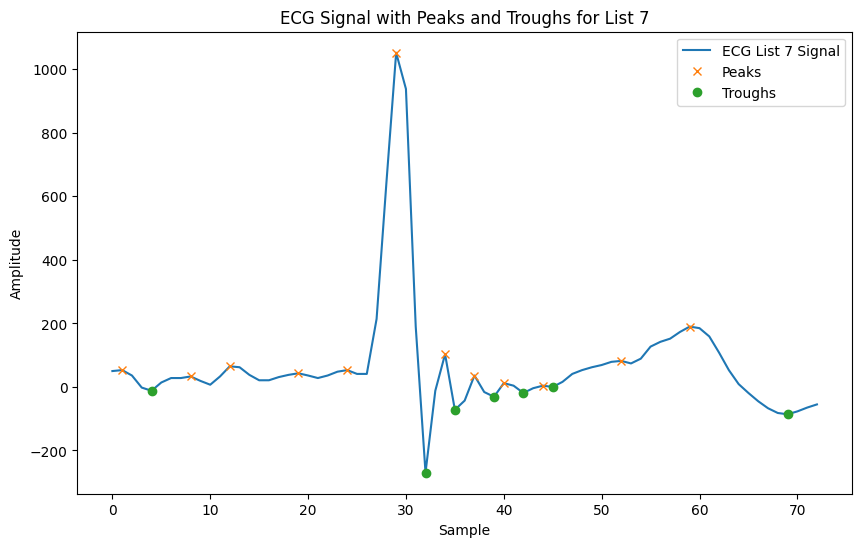

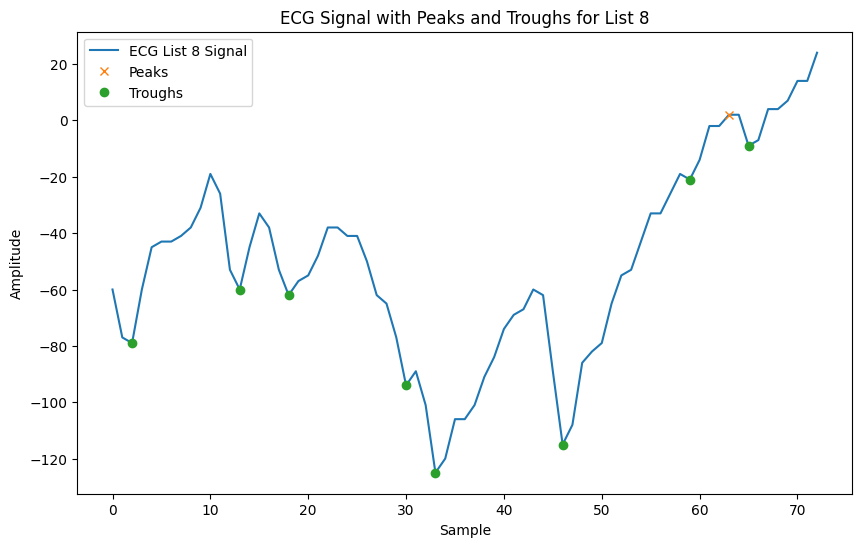

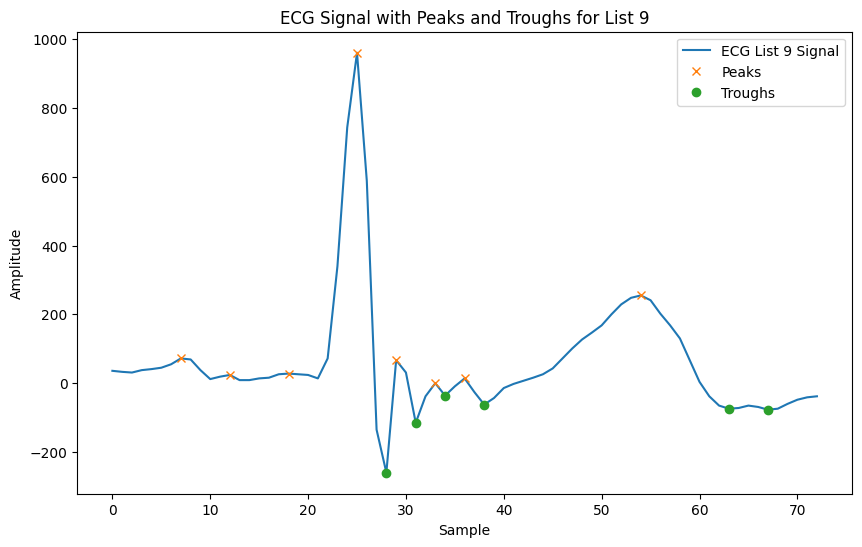

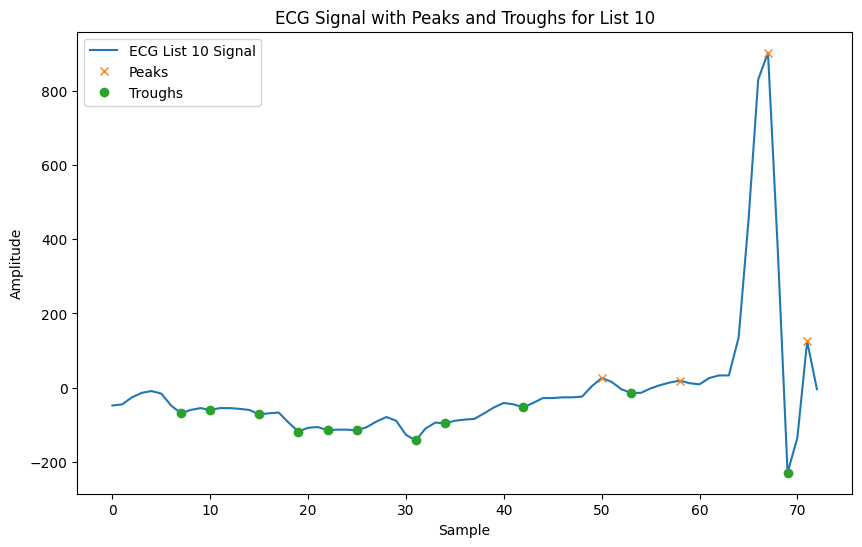

In [1]:


%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
from scipy.signal import find_peaks
from datetime import datetime
import csv


# Load the data
file_path = 'rawdata.csv'  # Adjust the path as necessary
data = pd.read_csv(file_path)

'''# Convert timestamps to seconds
data['time'] = pd.to_numeric(data['time'])
first_timestamp_ns = data['time'][0]
data['relative_time_s'] = (data['time'] - first_timestamp_ns) / 1e9'''

# Initialize a plot
plt.figure(figsize=(10, 6))



# Loop through rows 2 to 5 (Python indexing starts at 0, so we use 1:5)
for index, row in data.iloc[5:10].iterrows():
    ecg_list = np.array(eval(row['ecg']))  # Convert the string list to an actual list
    
    # Detect peaks
    peaks, _ = find_peaks(ecg_list, height=0)  # Adjust the 'height' parameter as needed for your data
    
    # Detect troughs by inverting the signal
    troughs, _ = find_peaks(-ecg_list, height=0)  # Invert signal with '-' and adjust 'height' as needed
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(ecg_list, label=f'ECG List {index+1} Signal')
    plt.plot(peaks, ecg_list[peaks], "x", label='Peaks')  # Mark peaks
    plt.plot(troughs, ecg_list[troughs], "o", label='Troughs')  # Mark troughs
    plt.title(f'ECG Signal with Peaks and Troughs for List {index+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()




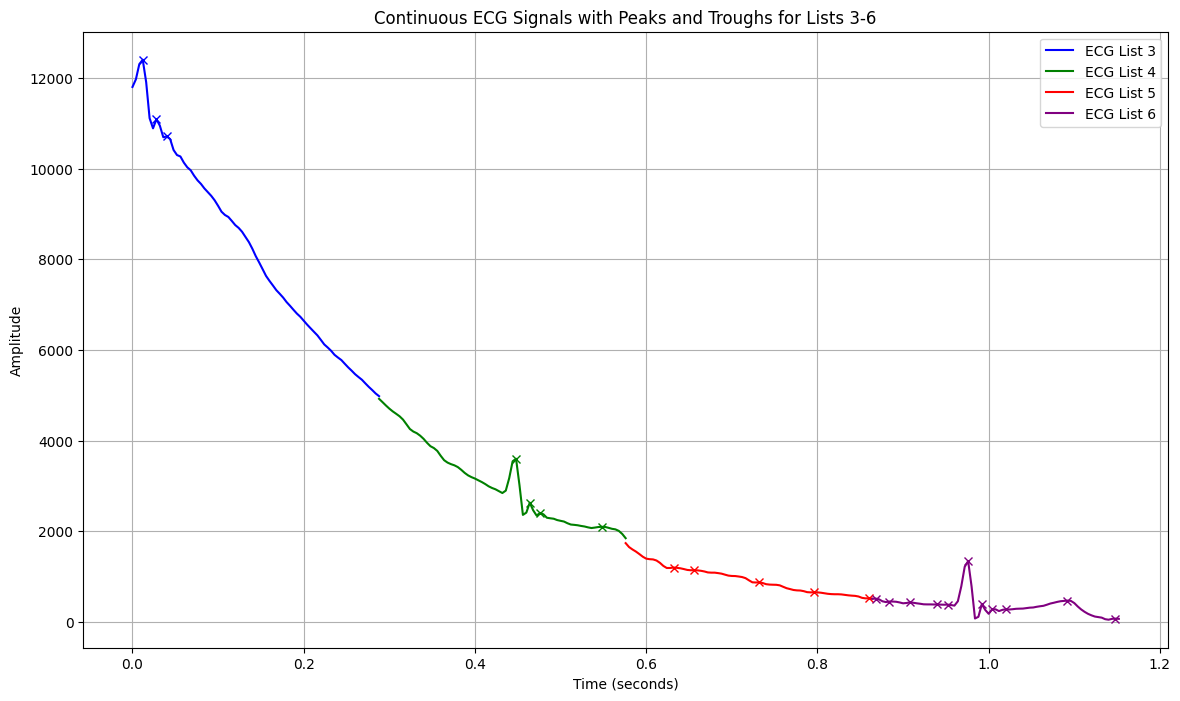

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the data
file_path = 'rawdata.csv'  # Adjust the path as necessary
data = pd.read_csv(file_path)

'''# Convert timestamps to seconds
data['time'] = pd.to_numeric(data['time'])
first_timestamp_ns = data['time'][0]
data['relative_time_s'] = (data['time'] - first_timestamp_ns) / 1e9'''

# Initialize a plot
plt.figure(figsize=(14, 8))

# Assuming a standard ECG sampling rate
sampling_rate = 250

# Initialize a variable to keep track of the current x-axis offset
current_offset = 0

# Colors for differentiation
colors = ['blue', 'green', 'red', 'purple']

# Process and plot each ECG list
for index, (color, (i, row)) in enumerate(zip(colors, data.iloc[1:5].iterrows())):
    ecg_list = np.array(eval(row['ecg']))  # Convert the string list to an actual list
    # Generate x values starting from the current offset
    x_values = np.arange(len(ecg_list)) / sampling_rate + current_offset
    
    # Detect peaks
    peaks, _ = find_peaks(ecg_list, height=0)
    # Adjust peaks' x positions by current offset
    peak_positions = peaks / sampling_rate + current_offset
    
    # Detect troughs by inverting the signal
    troughs, _ = find_peaks(-ecg_list, height=0)
    # Adjust troughs' x positions by current offset
    trough_positions = troughs / sampling_rate + current_offset
    
    # Plot
    plt.plot(x_values, ecg_list,label=f'ECG List {i+2}', color=color)
    plt.plot(peak_positions, ecg_list[peaks], "x", color=color)
    plt.plot(trough_positions, ecg_list[troughs], "o", color=color)
    
    # Update the offset for the next segment
    current_offset = x_values[-1]

# Customizing the plot
plt.title('Continuous ECG Signals with Peaks and Troughs for Lists 3-6')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from collections import deque

# loading
file_path = 'rawdata.csv'  # Adjust the path as necessary
data = pd.read_csv(file_path)

# convert timestamps to seconds
data['time'] = pd.to_numeric(data['time'])
first_timestamp_ns = data['time'][0]
data['relative_time_s'] = (data['time'] - first_timestamp_ns) / 1e9



# placeholder queues for storing ecg characteristics
r_peak_amplitudes = deque()
s_peak_amplitudes = deque()
q_peak_amplitudes= deque()

# Placeholder lists for storing ECG characteristics and their timestamps
r_peak_indices = deque()
s_peak_indices = deque()
q_peak_indices = deque()
qrs_durations = deque()


 # window size to look for s-peaks and q-peaks (before/after r-peaks)
search_window = 50


# loop through the desired ECG lists
for index, row in data.iterrows():
    ecg_list = np.array(eval(row['ecg']))  # Convert string list to actual list
    relative_time_s = data['relative_time_s']

    
    ''' R-Peak Extraction '''
    # detect r_peak indexes
    r_peaks, _ = find_peaks(ecg_list, height=1500)
    # find amplitudes r_peak indexes 
    for x in r_peaks:
        r_peak_amplitudes.extend(ecg_list[r_peaks])
        r_peak_indices.extend(r_peaks)


    ''' S-Peak Extraction '''
    for r_peak in r_peaks:
        # defining search window (immediately after r-peak to end of signal)
        start_index = r_peak + 1  
        end_index = min(r_peak + 1 + search_window, len(ecg_list))  
        
        # find index of minimum value in this window
        if start_index < len(ecg_list):  
            s_peaks,_ = find_peaks(((-ecg_list[start_index:end_index]) + start_index))
            s_peak_amplitudes.extend(ecg_list[s_peaks])
            s_peak_indices.extend(s_peaks + start_index)


    ''' Q-Peak Extraction '''
    for r_peak in r_peaks:
        # defining search window (start of signal until r-peak)
        start_index = max(0, r_peak - search_window)  
        end_index = r_peak
        
        if end_index > 0: 
            # find index of minimum value in this window
            q_peaks,_ = find_peaks(((-ecg_list[start_index:end_index]) + start_index))
            q_peak_amplitudes.extend(ecg_list[q_peaks])
            q_peak_indices.extend(q_peaks + start_index)


# Function to calculate QRS durations based on the located peaks
def calculate_qrs_durations(relative_time_s, q_peak_indices, s_peak_indices):
    for q_idx, s_idx in zip(q_peak_indices, s_peak_indices):
        qrs_duration = relative_time_s[s_idx] - relative_time_s[q_idx]
        qrs_durations.append(abs(qrs_duration/100))

# Example output of R-peaks and RR intervals for the first list
print("R-peaks:", r_peak_amplitudes)
print ("S Peaks:" , s_peak_amplitudes)
print ("Q Peaks:" , q_peak_amplitudes)
calculate_qrs_durations(relative_time_s, q_peak_indices, s_peak_indices)
print("QRS Durations (s):", list(qrs_durations))

R-peaks: deque([13751, 13939, 13934, 13896, 13751, 13939, 13934, 13896, 13751, 13939, 13934, 13896, 13751, 13939, 13934, 13896, 12400, 11089, 10708, 12400, 11089, 10708, 12400, 11089, 10708, 3600, 2632, 2405, 2099, 3600, 2632, 2405, 2099, 3600, 2632, 2405, 2099, 3600, 2632, 2405, 2099])
S Peaks: deque([5892, 8242, 9381, 6913, 5892, 12303, 11111, 11968, 4849, 4591, 3481, 4849, 3773, 3952])
Q Peaks: deque([13731, 13731, 13731, 13932, 10887, 2844, 2844, 2362, 2844, 2362, 3481, 3194, 3042, 2405])
QRS Durations (s): [0.0, 0.028070456399999985, 0.04491303541999997, 0.016842579019999988, 0.19650046826, 0.16842970667999999, 0.15158626298000002, 0.18527111584, 0.03368485285999998, 0.0224566703, 0.14596637327999995, 0.0224566703, 0.08982485011999998, 0.0]
